In [1]:
#To do lambdaの外部入力
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

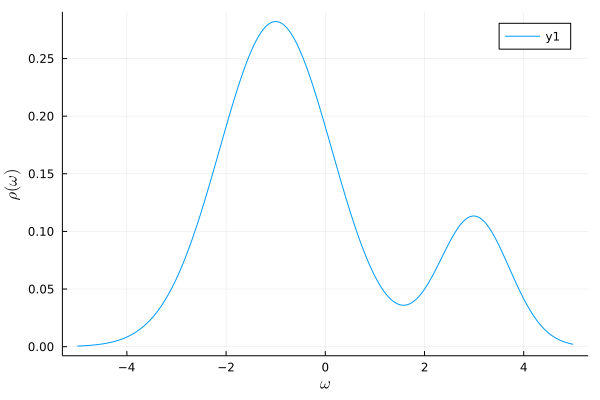

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 10
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* big.(rhol)
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

22

In [8]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [9]:
for i in 1:hnw
    test_smpl[i]= im*IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [10]:
N_real    =  1000
omega_max =  10.0
eta       =  1e-4
H_max     =  1
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

N_imag is setted as 17
N_imp 17


In [11]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.907579e-03     7.884882e-03
 * time: 0.0221250057220459


     1     1.117071e-03     4.038995e-03
 * time: 1.5357298851013184


     2     9.172998e-04     6.151682e-03
 * time: 1.9098708629608154


     3     4.984776e-04     1.464553e-03
 * time: 2.167855978012085


     4     4.445166e-04     1.083309e-04
 * time: 2.4428188800811768


     5     4.441520e-04     7.435671e-06
 * time: 2.7236390113830566


     6     4.441499e-04     1.329678e-06
 * time: 2.8898019790649414


     7     4.441499e-04     8.932837e-08
 * time: 3.1640968322753906


     8     4.441499e-04     5.511804e-09
 * time: 3.445150852203369


max_theta=0.174897972425744976048863907968517013170608955534325141212002155099034438843449093629211230166431146349358535376560256371666229139063018024767402222298124354
hardy optimization was success.
 41.095307 seconds (122.72 M allocations: 6.995 GiB, 5.85% gc time, 92.92% compilation time)


In [12]:
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     4.441499e-04     5.511804e-09
 * time: 5.3882598876953125e-5


max_theta=0.174897972425744976048863907968517013170608955534325141212002155099034438843449093629211230166431146349358535376560256371666229139063018024767402222298124354
hardy optimization was success.
  0.214440 seconds (2.04 M allocations: 136.702 MiB, 14.39% gc time, 41.71% compilation time)


In [13]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


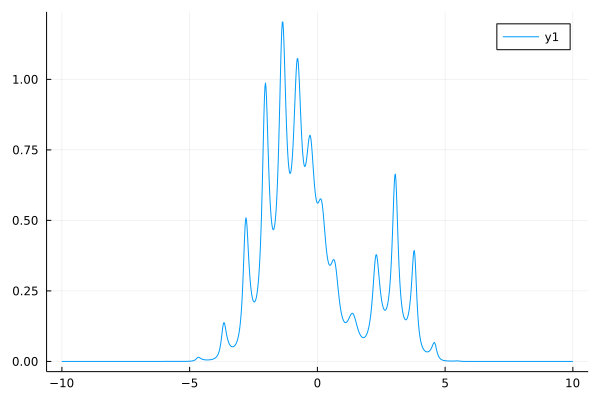

In [14]:
plot(real.(raw_reals.freq), imag.(raw_reals.val))
#plot!(omegas, rho.(omegas))

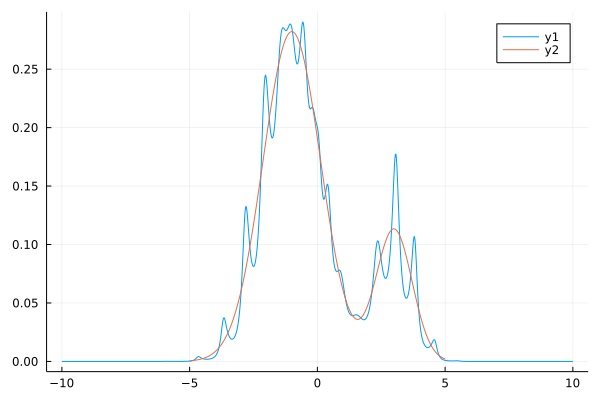

In [15]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [16]:
imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
#noopt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#opt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#noopt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
#opt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
noopt_raw_reals = Nevanlinna.RealDomainData(2000, omega_max, eta, T=T)
opt_raw_reals = Nevanlinna.RealDomainData(2000, omega_max, eta, T=T)
noopt_raw_reals.freq .= ((collect(1:2000).-1000)/1000)*2*pi*im/beta
opt_raw_reals.freq .= ((collect(1:2000).-1000)/1000)*2*pi*im/beta
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, noopt_raw_reals, phis)
ab_coeff  = zeros(ComplexF64, 2*sol.H) 
hardy_matrix = Nevanlinna.calc_hardy_matrix(noopt_raw_reals, sol.H)

Nevanlinna.evaluation!(noopt_raw_reals, abcd, sol.H, ab_coeff, hardy_matrix)
Nevanlinna.evaluation!(opt_raw_reals, abcd, sol.H, sol.ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.
max_theta=0.163617770264342410779451738807829836932455594061968513036663193827231270679389266138853045408996517391471006823499309630054378168668035704905027106023858086
hardy optimization was success.


true

In [17]:
using FastGaussQuadrature
using OMEinsum
using Interpolations

"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_green_z(rho, z::Vector{ComplexF64}, xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    newaxis = [CartesianIndex()]
    green_z = ein"q,q,wq->w"(
            quad_rule[2],
            rho.(quad_rule[1]),
            1 ./ (z[:, newaxis] .- quad_rule[1][newaxis, :])
        )
    return green_z
end

#exact_g = calc_green_z(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag])*im*pi/beta, -omega_max, omega_max, 1000)
exact_g = calc_green_z(rho, ((collect(1:2000).-1000)/1000)*2*pi*im/beta, -omega_max, omega_max, 10000)

rho_intpl = LinearInterpolation(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
reconst_g = calc_green_z(rho_intpl, ((collect(1:2000).-1000)/1000)*2*pi*im/beta, -omega_max, omega_max, 10000)

;

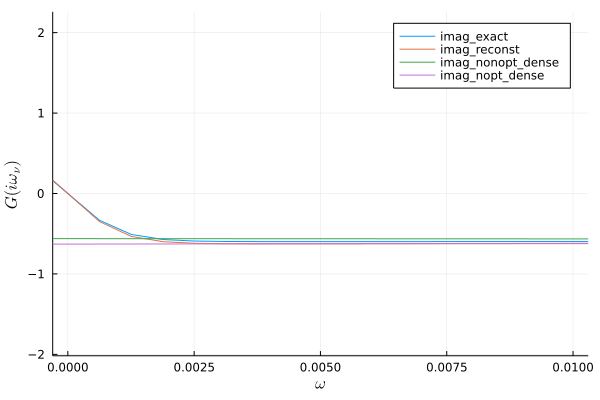

In [18]:
plot()
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(exact_g)), xlim=[0,0.3],label="real_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-opt_raw_reals.val)), label="real_nopt_dense")
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(imag.(exact_g)), xlim=[0,0.01],label="imag_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(imag.(reconst_g)), xlim=[0,0.01],label="imag_reconst", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(imag.(-opt_raw_reals.val)), label="imag_nopt_dense")

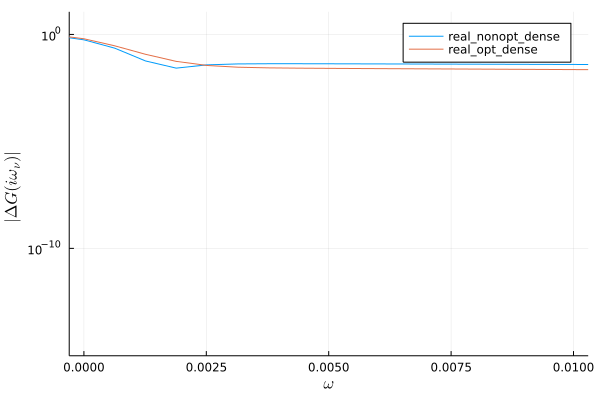

In [19]:
plot()
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-noopt_raw_reals.val-exact_g)), xlim = [0,0.01], label="real_nonopt_dense", xlabel=latexstring("\\omega"), ylabel=latexstring("|\\Delta G(i\\omega_\\nu)|"), yaxis=:log)
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-opt_raw_reals.val-exact_g)), label="real_opt_dense")

In [20]:
#plot()
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(exact_g)), label="real_exact", xlabel=latexstring("\\nu"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-opt_raw_reals.val)), label="real_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(real.(test_gw[1:N_imag])), label="real_sparse")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(exact_g)), label="imag_exact")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-opt_raw_reals.val)), label="imag_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(imag.(test_gw[1:N_imag])), label="imag_sparse")

In [21]:
#plot()
#plot(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-noopt_raw_reals.val.-exact_g)), yaxis=:log, label="abs_nonopt_dense", xlabel=latexstring("\\nu"), ylabel=latexstring("\\Delta |G(i\\omega_\\nu)|"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-opt_raw_reals.val-exact_g)), label="abs_opt_dense")

In [22]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [23]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#